In [2]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models

Hop size - 160 
Window Size - 512 
fft_size = 512

In [3]:
def preprocess_data(file_path, max_time_steps=109, sample_rate=22050, duration=3, n_mels=128):
    audio, _ = librosa.load(file_path, sr=sample_rate, duration=duration)

    # Extract Mel spectrogram using librosa
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Ensure all spectrograms have the same width (time steps)
    if mel_spectrogram.shape[1] < max_time_steps:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :max_time_steps]

    return mel_spectrogram

In [4]:
# Set your file paths and constants
TRAINING_LABEL = '/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'
TRAINING_DATA = '/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac'
VALIDATION_DATA = '/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_dev/flac'
VALIDATION_LABEL = '/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt'
SAMPLE_RATE = 22050  # Adjust if your sample rate is different
DURATION = 3  # Adjust the duration of your audio samples
N_MELS = 128  # Adjust the number of mel filters

In [5]:
# Load labels for training Data
train_labels = {}

with open(TRAINING_LABEL, 'r') as label_file:
    lines = label_file.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    train_labels[file_name] = label

X = []
y = []

max_time_steps = 109  # Define the maximum time steps for your model

for file_name, label in train_labels.items():
    file_path = os.path.join(TRAINING_DATA, file_name + ".flac")

    # Use the preprocess_data function
    mel_spectrogram = preprocess_data(file_path, max_time_steps=max_time_steps)

    X.append(mel_spectrogram)
    y.append(label)

X = np.array(X)
y = np.array(y)

# Reshape input data to match the required input shape for ResNet
X = X.reshape((X.shape[0], X.shape[1], X.shape[2], 1))

In [6]:
# Define input shape and number of classes
input_shape = X[0].shape
num_classes = 2  # Assuming you have two classes (0 and 1)

In [7]:
# Load and preprocess evaluation data
eval_X = []
eval_y = []

with open(VALIDATION_LABEL, 'r') as eval_label_file:
    eval_lines = eval_label_file.readlines()

eval_labels = {}

for line in eval_lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    eval_labels[file_name] = label

max_time_steps = 109  # Define the maximum time steps for your model

for file_name, label in eval_labels.items():
    file_path = os.path.join(VALIDATION_DATA, file_name + ".flac")

    # Use the preprocess_data function
    mel_spectrogram = preprocess_data(file_path, max_time_steps=max_time_steps)

    eval_X.append(mel_spectrogram)
    eval_y.append(label)

eval_X = np.array(eval_X)
eval_y = np.array(eval_y)


# Reshape input data to match the required input shape for ResNet
eval_X = eval_X.reshape((eval_X.shape[0], eval_X.shape[1], eval_X.shape[2], 1))

In [8]:
# Define the ResNet block
def resnet_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False):
    shortcut = x
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

# Build the ResNet model
def build_resnet(input_shape, num_classes):
    input_tensor = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, 7, strides=2, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # ResNet blocks
    for size in [64, 128, 256, 512]:
        x = resnet_block(x, size, conv_shortcut=True)
        x = resnet_block(x, size)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_tensor, outputs=x, name='resnet_model')
    return model

In [9]:
# Build ResNet model
resnet_model = build_resnet(input_shape, num_classes)

2023-11-15 14:24:42.837203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 14:24:43.635461: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22834 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:1a:00.0, compute capability: 7.5
2023-11-15 14:24:43.636087: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22757 MB memory:  -> device: 1, name: NVIDIA TITAN RTX, pci bus id: 0000:68:00.0, compute capability: 7.5


In [10]:
# Compile the model
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Display the model summary
resnet_model.summary()

Model: "resnet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 109, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 55, 64)   3200        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 55, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [14]:
# Train the model
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

epochs = 50  # Adjust the number of epochs as needed

history = resnet_model.fit(X_train, y_train, epochs=epochs, validation_data=(eval_X, eval_y))

# Evaluate the model on the test set
loss, accuracy = history.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%')

# Evaluate the model on the separate evaluation dataset
eval_loss, eval_accuracy = history.evaluate(eval_X, eval_y)
print(f'Evaluation Loss: {eval_loss:.4f}, Evaluation Accuracy: {eval_accuracy * 100:.2f}%')

Epoch 1/50
635/635 [==============================] - 78s 123ms/step - loss: 0.1200 - accuracy: 0.9518 - val_loss: 0.6355 - val_accuracy: 0.9019
Epoch 2/50
635/635 [==============================] - 76s 120ms/step - loss: 0.0704 - accuracy: 0.9742 - val_loss: 2.2219 - val_accuracy: 0.8974
Epoch 3/50
635/635 [==============================] - 76s 120ms/step - loss: 0.0476 - accuracy: 0.9827 - val_loss: 0.4792 - val_accuracy: 0.9025
Epoch 4/50
635/635 [==============================] - 77s 121ms/step - loss: 0.0344 - accuracy: 0.9872 - val_loss: 3.3990 - val_accuracy: 0.5327
Epoch 5/50
635/635 [==============================] - 77s 121ms/step - loss: 0.0301 - accuracy: 0.9893 - val_loss: 3.7142 - val_accuracy: 0.8974
Epoch 6/50
635/635 [==============================] - 77s 121ms/step - loss: 0.0242 - accuracy: 0.9916 - val_loss: 1.0153 - val_accuracy: 0.8381
Epoch 7/50
635/635 [==============================] - 77s 121ms/step - loss: 0.0204 - accuracy: 0.9933 - val_loss: 0.0451 - val_ac

AttributeError: 'History' object has no attribute 'evaluate'

In [15]:
# Evaluate the model on the test set
loss, accuracy = resnet_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%')

# Evaluate the model on the separate evaluation dataset
eval_loss, eval_accuracy = resnet_model.evaluate(eval_X, eval_y)
print(f'Evaluation Loss: {eval_loss:.4f}, Evaluation Accuracy: {eval_accuracy * 100:.2f}%')

159/159 [==============================] - 5s 32ms/step - loss: 0.0041 - accuracy: 0.9982
Test Loss: 0.0041, Test Accuracy: 99.82%
777/777 [==============================] - 24s 30ms/step - loss: 0.0409 - accuracy: 0.9915
Evaluation Loss: 0.0409, Evaluation Accuracy: 99.15%


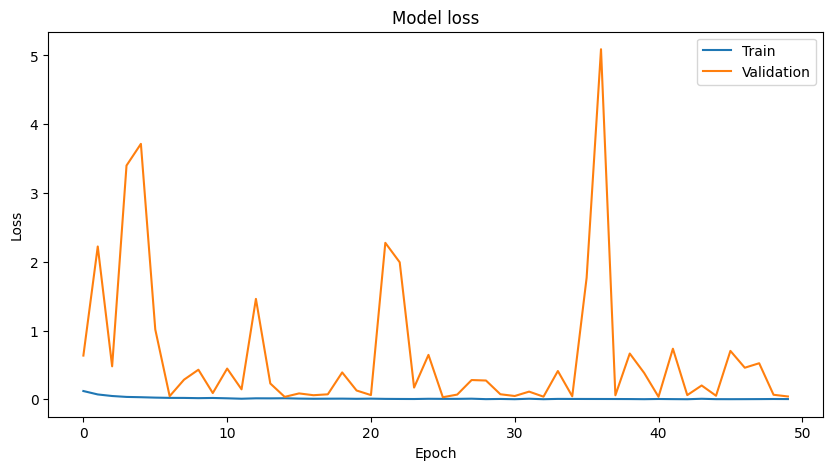

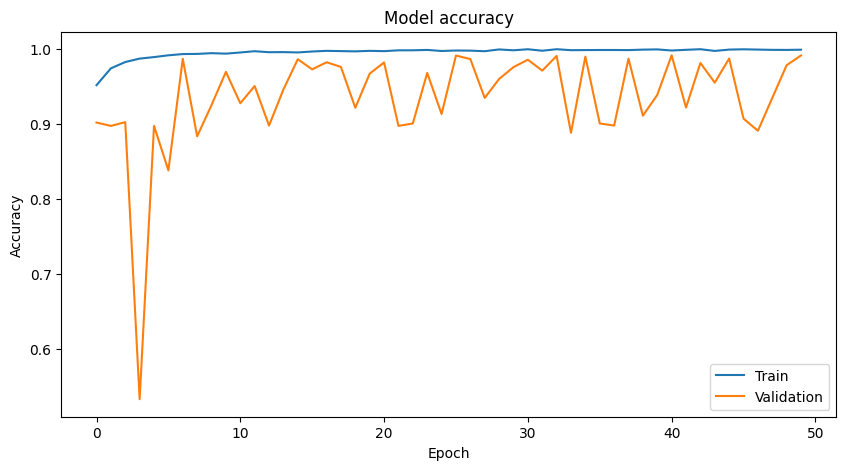

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [18]:
# Save the trained model
resnet_model.save("models/basic_resnet.h5")